In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Attention lstm implementation

Mounted at /content/gdrive
/content/gdrive/My Drive/Attention lstm implementation


In [ ]:
import pandas as pd
import sklearn.metrics as metrique
from pandas import Series
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import LSTM, Dense, Embedding, Dropout,Input, Attention, Layer, Concatenate, Permute, Dot, Multiply, Flatten
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.models import Sequential
from keras import backend as K, regularizers, Model, metrics
from keras.backend import cast

In [ ]:
data = pd.read_csv('creditcard.csv', na_filter=True)
col_del = ['Time' ,'V5', 'V6', 'V7', 'V8', 'V9','V13','V15', 'V16',  'V18', 'V19', 'V20','V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [ ]:
tr_data = data.drop(col_del,axis =1)
tr_data.shape

(284807, 10)

In [ ]:
X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']

In [ ]:
# Generate and plot imbalanced classification dataset
from collections import Counter
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(tr_data['Class'])
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(tr_data['Class'] == label)[0]

Counter({0: 284315, 1: 492})


In [ ]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_r, y = oversample.fit_resample(X, tr_data['Class'])
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]

In [ ]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
X_r2 = StandardScaler().fit_transform(X_r)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_r2, y, test_size=0.3)

In [ ]:
X_train.shape

(454904, 9)

In [ ]:
X_test.shape

(113726, 9)

In [ ]:
# design network
np.random.seed(7)

# X_train et X_val sont des dataframe qui contient les features
train_LSTM_X=X_train
val_LSTM_X=X_test

## Reshape input to be 3D [samples, timesteps, features] (format requis par LSTM)
train_LSTM_X = train_LSTM_X.reshape((train_LSTM_X.shape[0], 1, train_LSTM_X.shape[1]))
val_LSTM_X = val_LSTM_X.reshape((val_LSTM_X.shape[0], 1, val_LSTM_X.shape[1]))

## Recuperation des labels
train_LSTM_y=y_train
val_LSTM_y=y_test

In [ ]:
inputs=Input((1,9))
x1=LSTM(50,dropout=0.3,recurrent_dropout=0.2)(inputs)
x2=LSTM(50,dropout=0.3,recurrent_dropout=0.2)(x1)
outputs=Dense(1,activation='sigmoid')(x2)
model=Model(inputs,outputs)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history=model.fit(train_LSTM_X, train_LSTM_y,epochs=100,batch_size=20000, validation_data=(val_LSTM_X, val_LSTM_y))

In [ ]:
# save model and architecture to single file
model.save('Save_Model.h5')
print("Saved model to disk")

Saved model to disk


In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('Save_Model.h5')
# summarize model.
model.summary()

In [ ]:
# evaluate the model
_, train_acc = model.evaluate(train_LSTM_X, train_LSTM_y, verbose=0)
_, test_acc = model.evaluate(val_LSTM_X, val_LSTM_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.937, Test: 0.937


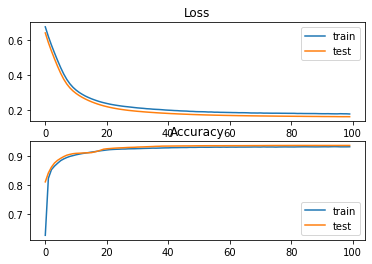

In [ ]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(val_LSTM_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(val_LSTM_y, yhat_probs)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(val_LSTM_y, yhat_probs)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(val_LSTM_y, yhat_probs)
print('Recall: %f' % recall)


Accuracy: 0.937135
Precision: 0.987155
Recall: 0.886014


In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_true=val_LSTM_y, y_pred=yhat_probs)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = ['Normal','Fraud']

Confusion matrix, without normalization
[[84164   985]
 [ 9739 75701]]


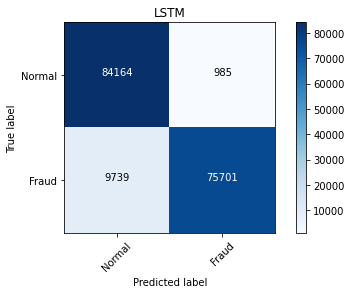

In [ ]:
plot_confusion_matrix(cm=cm, classes=labels, title='LSTM')

In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
inputs1=Input((1,9))
att_in=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(inputs1)
att_in_1=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(att_in)
att_out=attention()(att_in_1)
outputs1=Dense(1,activation='sigmoid',trainable=True)(att_out)
model1=Model(inputs1,outputs1)

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1=model1.fit(train_LSTM_X, train_LSTM_y,epochs=100,batch_size=30000, validation_data=(val_LSTM_X, val_LSTM_y))

In [ ]:
# save Attention model and architecture to single file
model1.save('Save_Model_Attention.h5')
print("Saved model to disk")

Saved model to disk


In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model1 = load_model('Save_Model_Attention.h5')
# summarize model.
model1.summary()

In [ ]:
# evaluate the model
_, train_acc = model1.evaluate(train_LSTM_X, train_LSTM_y, verbose=0)
_, test_acc = model1.evaluate(val_LSTM_X, val_LSTM_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.9677, Test: 0.9672


In [ ]:
# predict probabilities for test set
yhat_probs1 = model1.predict(val_LSTM_X, verbose=0)
# reduce to 1d array
yhat_probs1 = yhat_probs1[:, 0]

In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(val_LSTM_y, yhat_probs1)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(val_LSTM_y, yhat_probs1)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(val_LSTM_y, yhat_probs1)
print('Recall: %f' % recall)


Accuracy: 0.9672
Precision: 0.9885
Recall: 0.9191


In [ ]:
cm1 = confusion_matrix(y_true=val_LSTM_y, y_pred=yhat_probs1)

Confusion matrix, without normalization
[[84296   879]
 [ 9297 76117]]


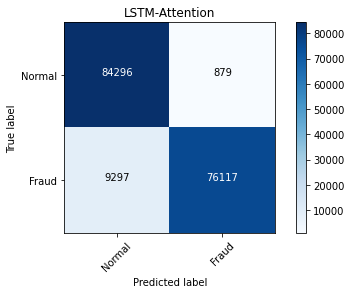

In [ ]:
plot_confusion_matrix(cm=cm1, classes=labels, title='LSTM-Attention', normalize=False)